# Lecture 1

In [9]:
# Utils
from math import atan2

def orientation(a, b, c):
    ob = (b[0]-a[0], b[1]-a[1])
    oc = (c[0]-a[0], c[1]-a[1])
    det = ob[0]*oc[1]-ob[1]*oc[0]
    return -1 if det<0 else 1 if det>0 else 0

# Checks if the point b its on the segment ac
def onSegment(a,b,c):
    on_x_proyection = b[0]<=max(a[0],c[0]) and b[0]>= min(a[0],c[0])
    # print(f"pr_x: {on_x_proyection}")
    on_y_proyection = b[1]<=max(a[1],c[1]) and b[1]>= min(a[1],c[1])
    # print(f"pr_y: {on_y_proyection}")
    if(on_x_proyection and on_y_proyection): return True
    return False

def doIntersect(a,b,c,d):
    # Orientations between segment and the other points
    o_c_segment_ab = orientation(a,b,c)
    o_d_segment_ab = orientation(a,b,d)
    o_a_segment_cd = orientation(c,d,a)
    o_b_segment_cd = orientation(c,d,b)

    # Case 1
    if(o_c_segment_ab != o_d_segment_ab and o_a_segment_cd != o_b_segment_cd):
        return True
    
    # Special cases when they are colinear
    # print("Case 1")
    if(o_c_segment_ab == 0 and onSegment(a,c,b)): return True
    # print("Case 2")
    if(o_d_segment_ab == 0 and onSegment(a,d,b)): return True
    # print("Case 3")
    if(o_a_segment_cd == 0 and onSegment(c,a,d)): return True
    # print("Case 4")
    if(o_b_segment_cd == 0 and onSegment(c,b,d)): return True

    return False

def do_intersect(s1,s2):
    return doIntersect(s1[0],s1[1],s2[0],s2[1])

def get_convex_hull(p):
    n = len(p)
    if n<3: return
    hull = []
    s_y = min(p, key=lambda x: x[1])
    p.sort(key=lambda x: (atan2(x[1]-s_y[1], x[0]-s_y[0]), -x[1], x[0]))
    for point in p:
        while len(hull)>=2 and orientation(hull[-2], hull[-1], point) <= 0:
            hull.pop()
        hull.append(point)
    return hull

# Finds the point of intersection between two segments
def get_intersection_point(s1,s2):
    x1, y1 = s1[0]
    x2, y2 = s1[1]
    x3, y3 = s2[0]
    x4, y4 = s2[1]
    # print(f"({x1},{y1})-({x2},{y2})")
    # print(f"({x3},{y3})-({x4},{y4})")
    # print("----")
    # Denominator
    den = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    # print(f"den: {den}")
    if den == 0: return None
    # Numerators
    t = (x1-x3)*(y3-y4) - (y1-y3)*(x3-x4)
    u = (x1-x2)*(y1-y3) - (y1-y2)*(x1-x3)
    # print(f"t: {t}")
    # print(f"u: {u}")
    # print("----")
    t = t/den
    u = -u/den
    # print(f"t: {t}")
    # print(f"u: {u}")
    if t>=0 and t<=1 and u>=0 and u<=1:
        x = x1 + t*(x2-x1)
        y = y1 + t*(y2-y1)
        return (x,y)
    return None

# Sweep line for finding the intersection of segments

https://www.geeksforgeeks.org/given-a-set-of-line-segments-find-if-any-two-segments-intersect/

In [43]:
# Bentley–Ottmann algorithm to find the intersection points between segments

import heapq
from sortedcontainers import SortedDict
import bisect

class EventPoint:
    def __init__(self, x, seg=None, is_left=True):
        self.x = x
        self.seg = seg
        self.is_left = is_left

    def __lt__(self, other):
        return self.x < other.x

class Segment:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.slope = (p2[1] - p1[1]) / (p2[0] - p1[0]) if p2[0] != p1[0] else None

    def __lt__(self, other):
        return self.slope < other.slope

def bentley_ottmann(segments):
    event_queue = []
    status = SortedDict()
    intersections = []

    for seg in segments:
        heapq.heappush(event_queue, EventPoint(seg.p1[0], seg, True))
        heapq.heappush(event_queue, EventPoint(seg.p2[0], seg, False))

    while event_queue:
        event = heapq.heappop(event_queue)
        if event.is_left:
            status[event.seg] = event.seg
            segs = list(status.keys())
            index = bisect.bisect_right(segs, event.seg)
            above = segs[index] if index < len(segs) else None
            below = segs[index - 1] if index > 0 else None
            if above:
                s1 = (event.seg.p1, event.seg.p2)
                s2 = (above.p1, above.p2)
                if do_intersect(s1, s2):
                    res = get_intersection_point(s1,s2)
                    if res: intersections.append(res)
            if below:
                s1 = (event.seg.p1, event.seg.p2)
                s2 = (below.p1, below.p2)
                if do_intersect(s1, s2):
                    res = get_intersection_point(s1,s2)
                    if res: intersections.append(res)
        else:
            segs = list(status.keys())
            index = bisect.bisect_left(segs, event.seg)
            above = segs[index] if index < len(segs) else None
            below = segs[index - 1] if index > 0 else None
            if above and below:
                s1 = (above.p1, above.p2)
                s2 = (below.p1, below.p2)
                if do_intersect(s1, s2):
                    res = get_intersection_point(s1,s2)
                    if res: intersections.append(res)
            try:
                del status[event.seg]
            except KeyError:
                pass

    return intersections


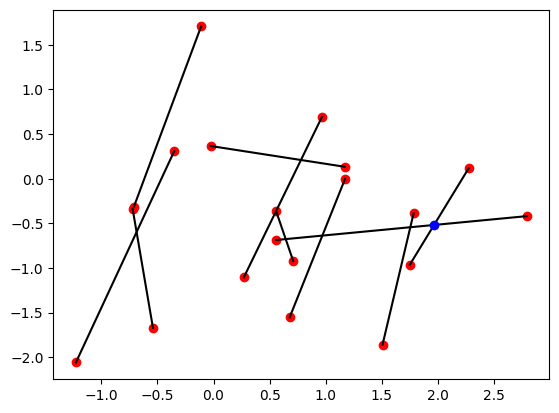

In [70]:
import matplotlib.pyplot as plt
from random import gauss

def plot_segments(s):
    for segment in s:
        x = [segment.p1[0], segment.p2[0]]
        y = [segment.p1[1], segment.p2[1]]
        plt.plot(x, y, 'k-')

def plot_points(p):
    x = [x for x, _ in p]
    y = [y for _, y in p]
    plt.plot(x, y, 'ro')

def plot_intersections(intersections):
    x = [point[0] for point in intersections]
    y = [point[1] for point in intersections]
    plt.plot(x, y, 'bo')

def main():
    p = []
    segments = []
    for _ in range(10):
        p1 = (gauss(0, 1), gauss(0, 1))
        p2 = (gauss(0, 1), gauss(0, 1))
        p.append(p1)
        p.append(p2)
        segments.append(Segment(p1, p2))

    plot_points(p)
    plot_segments(segments)
    intersections = bentley_ottmann(segments)
    plot_intersections(intersections)
    plt.show()

if __name__ == "__main__":
    main()

# Lecture 2

## Doubly Connected Edge List (DCEL)

Double connected edge list (DCEL) is a data structure to represent a planar subdivision. It is a half-edge data structure which is used to represent a subdivision of the Euclidean plane into a set of polygons. It is used to represent the planar subdivision in computational geometry.

In [4]:
# DCEL

import math as m

# Utils
def findHAngle(dx, dy):
    """Determines the angle with respect to the x axis of a segment
    of coordinates dx and dy
    """
    l = m.sqrt(dx*dx + dy*dy)
    if dy > 0:
        return m.acos(dx/l)
    else:
        return 2*m.pi - m.acos(dx/l)

class Vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.hedges = [] # list of halfedges whose tail is this vertex

    def __eq__(self, other):
        if isinstance(other, Vertex):
            return self.x == other.x and self.y == other.y
        return NotImplemented

    def sortHedges(self):
        self.hedges.sort(key=lambda a: a.angle, reverse=True)

    def __repr__(self):
        return "({0},{1})".format(self.x, self.y)

class Hedge:
    # v1 -> v2
    def __init__(self, v1, v2):
        self.prev = None
        self.twin = None
        self.next = None
        self.tail = v1
        self.face = None
        self.angle = findHAngle(v2.x-v1.x, v2.y-v1.y)

    def __eq__(self, other):
        return self.tail == other.tail

myHedge = Hedge(Vertex(0,0), Vertex(1,1))
myHedge2 = Hedge(Vertex(0,1.1), Vertex(1,1))
print(myHedge == myHedge2)
print(myHedge.angle)
print(myHedge2.angle)

True
0.7853981633974484
0.7853981633974484
